# Home assigment 3

Please give your name below:

In [1]:
name='Alexander Hedene'

## Exercise 1

You will be designing a control rod and study the control rod worth in a simple cylindric reactor. Your task will be to implement the geometry of a homogeneous cylindric reactor with a "control rod" placed in it. You will be modifying your model in order to move the control rod to investigate how the k-effective and the reactivity changes. You will be given a homogenenous mixture of enriched uranium and water. You can modify the U-235 content if you feel needed. The goal is that the reactor is supercritical when the control rod is not inserted, and it is subcritical when the control rod is fully inserted.

Your tasks are:

1. Build a cylinder core with `openmc.ZCylinder` and `openmc.ZPlane` surfaces. Make the radius of the cylinder 25cm, and the height of the cylinder 50 cm. You can use the homogeneous uranium-water mixture given below as a starting point.
2. Design a control rod as a homogeneous cell made of some neutron absorbing material (for example boron, boron-carbide). You are free to choose the material and the geometry. It can be a simple cylinder, or a rectangular prism, or a hexagonal prism, or it can be multiple cylinders as well. Unleash your creativity.
3. Write a function which has an input for the rod position (the length inserted into the core), and which returns an openMC `Model()`) (see Datalab 10).
4. Calculate the reactivity of the core when the rod is withdrawn. From this you figure out the reactivity reserve of the core (our margin to criticality).
5. Move the rod in steps into the reactor, and calculate the control rod worth at that location (ie. how much the k-effective, and the reactivity decreased after inserting the rod to the given position). 
6. Find the critical control rod position (you can use the `openmc.search_for_keff` function, or manual trial and error).
7. Plot the controd rod worth vs rod position.

Hint1: there are multiple ways to get into this problem. You can implement a control rod with fixed length, which when withdrawn from the core is infact located above the core as in practice, then insertion of the control rod means that you move the top and bottom bounding surfaces of the rod. But you can also just assume that there is some volume inside the reactor, which has its top surface always at the top of the reactor, and insertion is achieved by increasing the length of this cell. Care must be taken however for both whether the boundary condition of the control rod surfaces set in openMC is vacuum or the default transmissive (where particles freely pass through the surface), since the parts of the rod inside the core need to have a transmissive boundary, whereas the parts outside of the core need a vacuum boundary. Alternatively, you can surround the core with some cell which accommodates your whole core and the control rod (filled either with reflector material or void -ie. you do not specify the material), and include vacuum boundaries on the surfaces of this cell, then you can keep default transmissive boundaries on the control rod and core surfaces.

Hint2: Use enough particles per simulation so that the k-effective has a reasonably low uncertainty, but do not stress much on this (ie. don't do much longer than few minutes runs per rod position).

Hint3: It might be inefficient to launch your particles inside the control rod, so make sure you launch them in fuel material. You can for example include more source points, or use volume sources (see the [user's guide](https://docs.openmc.org/en/stable/usersguide/settings.html))

![options](ha3-1_controlrod.png)

In [2]:
import openmc
import numpy as np
import matplotlib.pyplot as plt

fuel_R = 25 # [cm]
fuel_h = 50 # [cm] 
z_bot_fuel = -fuel_h/2 # [cm] 
z_top_fuel = fuel_h/2 # [cm] 

rod_R = 10 # [cm]

def pincell(rod_insertion):
    rod_insurtion = min((z_top_fuel - z_bot_fuel), rod_insertion)
    
    fuelm = openmc.Material(1,"uo2")
    fuelm.set_density('g/cm3', 10.0)
    fuelm.add_nuclide('U235', 0.00229)
    fuelm.add_nuclide('U238', 0.13847)
    fuelm.add_nuclide('O16', 0.29)
    fuelm.add_nuclide('H1', 0.57)
    fuelm.add_s_alpha_beta('c_H_in_H2O')

    rodm = openmc.Material()
    rodm.add_element('B', 4.0)
    rodm.add_element('C', 1.0)
    rodm.set_density('g/cm3', 2.5)

    
    mats = openmc.Materials([fuelm, rodm])

    fuel_cyl = openmc.ZCylinder(r=fuel_R)
    fuel_z_bot = openmc.ZPlane(z0=z_bot_fuel)
    fuel_z_top = openmc.ZPlane(z0=z_top_fuel)

    rod_cyl = openmc.ZCylinder(r=rod_R)
    rod_z_bot = openmc.ZPlane(z0=(z_top_fuel - rod_insertion))
    rod_z_top = openmc.ZPlane(z0=z_top_fuel)

    rod_region = -rod_cyl & +rod_z_bot & -rod_z_top
    fuel_region = -fuel_cyl & +fuel_z_bot & -fuel_z_top & ~rod_region
    

    fuel = openmc.Cell(1, 'fuel')
    fuel.fill = fuelm
    fuel.region = fuel_region

    rod = openmc.Cell(2, 'control rod')
    rod.fill = rodm
    rod.region = rod_region

   # Void region surfaces
    void_radius = 2.5 * fuel_R # I did not know how to choose this multiplier, so I took a random guess from gbt
    void_height = 1.4 * fuel_h # I did not know how to choose this multiplier, so I took a random guess from gbt
    void_cyl = openmc.ZCylinder(r=void_radius, boundary_type='vacuum')
    void_z_bot = openmc.ZPlane(z0=-void_height/2, boundary_type='vacuum')
    void_z_top = openmc.ZPlane(z0=void_height/2, boundary_type='vacuum')

    void_region = -void_cyl & +void_z_bot & -void_z_top & ~rod_region & ~fuel_region
    
    
    void_cell = openmc.Cell(3, "Outside (void)")
    void_cell.region = void_region

    root = openmc.Universe(cells=(fuel, rod, void_cell))

    geom = openmc.Geometry()
    geom.root_universe = root

    # Set a cylindrical source inside the fuel volume. None outside the fuel, and none inside the rod.
    # I felt like this would create as much of a uniform destribution as possible.
    spatial = openmc.stats.CylindricalIndependent(
        r=openmc.stats.Uniform(rod_R, fuel_R),
        phi=openmc.stats.Uniform(0.0, 2*np.pi),
        z=openmc.stats.Uniform(z_bot_fuel, z_top_fuel),
        origin=(0.0, 0.0, 0.0),
    )
    src = openmc.Source(space=spatial)

    settings = openmc.Settings()
    settings.source = src
    settings.batches = 120
    settings.inactive = 20
    settings.particles = 20000
    settings.output = {'tallies': False}
    model = openmc.Model(geom, mats, settings)
    return model


In [3]:
# Function that calculates keff for a rod_pos. This can be a vector.
print("hej")
def find_keff(rod_pos):
    k_effs = []
    for pos in rod_pos:
        mod = pincell(pos)
        output = mod.run()
        sp = openmc.StatePoint('statepoint.120.h5')
        k_effs.append(sp.keff.nominal_value)
        os.system('rm *h5')
    return k_effs

hej


In [4]:
# straght forward function.
def get_reactivity(k):
    return (np.array(k)-1)/np.array(k)
    

In [5]:
import os
import numpy as np
os.system('rm *h5')

keffs = find_keff([0])
# Calculate reactivity in pcm for  
rho = get_reactivity(keffs) * 1e5  # pcm
print(f"Rod withdrawn k_eff = {keffs[0]:.5f}")
print(f"Rod withdrawn reactivity = {rho[0]:.1f} pcm")


rm: cannot remove '*h5': No such file or directory


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Reactivity reserve
At the start without any control rod the reactor have keff = 1.05346 and a reactivity reserve of 5074.4 pcm.

In [6]:
# Tries different rod positions from 0 to 50cm with 25 total steps.
rod_pos = np.linspace(0, 50, 25)
keffs = find_keff(rod_pos)
keff_decrease = np.array(keffs)-keffs[0]
rho = get_reactivity(keffs) * 1e5  # pcm
rho_decrease = np.array(rho)-rho[0]


/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading U235 from /root/endfb-vii.1-hdf5/neutron/U235.h5
 Reading U238 from /root/endfb-vii.1-hdf5/neutron/U238.h5
 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.90881
        2/1    0.98775
        3/1    0.99134
        4/1    1.00151
        5/1    1.00158
        6/1    1.

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.90666
        2/1    0.97357
        3/1    0.99820
        4/1    0.99867
        5/1    1.01765
        6/1    1.04082
        7/1    1.01666
        8/1    1.05368
        9/1    1.05235
       10/1    1.05029
       11/1    1.0

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.89255
        2/1    0.94504
        3/1    0.99069
        4/1    1.00701
        5/1    1.00065
        6/1    1.02037
        7/1    1.01813
        8/1    1.01892
        9/1    1.04122
       10/1    1.04697
       11/1    1.02382
       12/1    1.02972
       13/1    1.04705
     

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.88528
        2/1    0.96463
        3/1    0.94789
        4/1    0.98928
        5/1    1.00221
        6/1    1.01654
        7/1    1.02582
        8/1    1.02793
        9/1    1.02477
       10/1    1.02982
       11/1    1.0

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading U238 from /root/endfb-vii.1-hdf5/neutron/U238.h5
 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.88930
        2/1    0.93912
        3/1    0.95990
        4/1    0.98314
        5/1    0.96293
        6/1    1.00638
        7/1    1.01811
        8/1    1.01232
      

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.88270
        2/1    0.95425
        3/1    0.94634
        4/1    0.98737
        5/1    0.98597
        6/1    1.00372
        7/1    1.01046
        8/1    0.99610
        9/1    1.00459
       10/1    1.00211
       11/1    1.01700
       12/1    1.01670
       13/1    1.02173
     

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading U235 from /root/endfb-vii.1-hdf5/neutron/U235.h5
 Reading U238 from /root/endfb-vii.1-hdf5/neutron/U238.h5
 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.86718
        2/1    0.93064
        3/1    0.93129
        4/1    0.96528
        5/1    0.95804
        6/1    0.

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading U238 from /root/endfb-vii.1-hdf5/neutron/U238.h5
 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.84846
        2/1    0.90382
        3/1    0.91268
        4/1    0.91442
        5/1    0.92356
        6/1    0.93779
        7/1    0.94104
        8/1    0.92809
      

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.84508
        2/1    0.90984
        3/1    0.91729
        4/1    0.92965
        5/1    0.92882
        6/1    0.92321
        7/1    0.91912
        8/1    0.93151
        9/1    0.93575
       10/1    0.93886
       11/1    0.9

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading U238 from /root/endfb-vii.1-hdf5/neutron/U238.h5
 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.83417
        2/1    0.88687
        3/1    0.89773
        4/1    0.88989
        5/1    0.92024
        6/1    0.91761
        7/1    0.91651
        8/1    0.90731
      

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

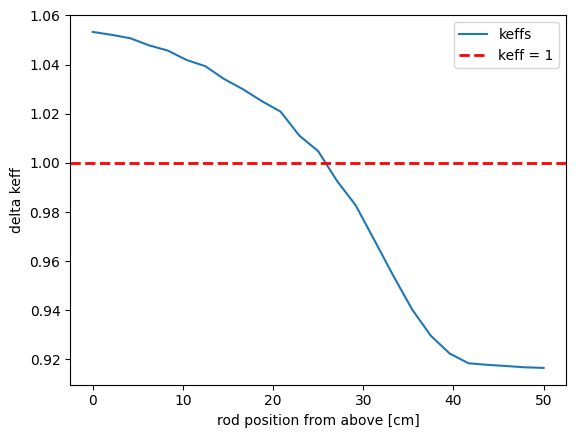

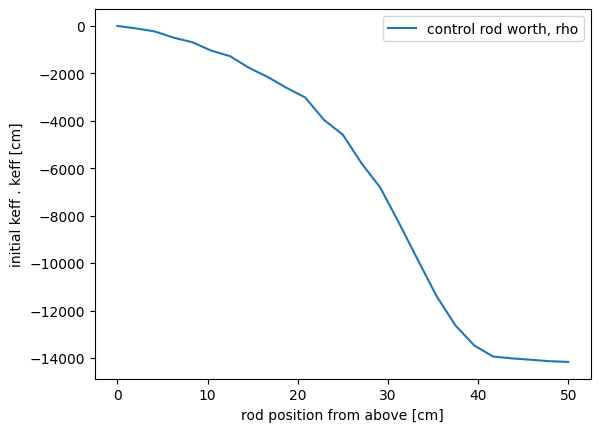

In [7]:
# Here i plot the rod worth and keff worth, i.e. keff[0]-keff vs rod pos and reactivity[0] - reactivity vs rod pos
plt.figure()
plt.plot(rod_pos, keffs, label='keffs')
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='keff = 1')
plt.xlabel('rod position from above [cm]')
plt.ylabel('delta keff')
plt.legend()
plt.show()


plt.figure()
plt.plot(rod_pos, rho_decrease, label='control rod worth, rho')
plt.xlabel('rod position from above [cm]')
plt.ylabel('initial keff . keff [cm]')
plt.legend()
plt.show()


In [8]:
# Optimization to find best rod depth.
opt_depth, guesses, opt_keffs = openmc.search_for_keff(pincell, target=1, bracket=[0, 50],
                                                  tol=1e-2, print_iterations=True)

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading U235 from /root/endfb-vii.1-hdf5/neutron/U235.h5
 Reading U238 from /root/endfb-vii.1-hdf5/neutron/U238.h5
 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.82584
        2/1    0.88787
        3/1    0.89589
        4/1    0.89971
        5/1    0.91016
        6/1    0.

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.86718
        2/1    0.93064
        3/1    0.93129
        4/1    0.96528
        5/1    0.95804
        6/1    0.96688
        7/1    0.98631
        8/1    0.99149
        9/1    0.97829
       10/1    0.98394
       11/1    0.9

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading U238 from /root/endfb-vii.1-hdf5/neutron/U238.h5
 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.87368
        2/1    0.91826
        3/1    0.94287
        4/1    0.96886
        5/1    0.93665
        6/1    0.95762
        7/1    0.98057
        8/1    0.98046
      

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading U238 from /root/endfb-vii.1-hdf5/neutron/U238.h5
 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.86622
        2/1    0.91467
        3/1    0.94136
        4/1    0.95539
        5/1    0.96674
        6/1    0.97506
        7/1    0.99664
        8/1    0.98123
      

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading O16 from /root/endfb-vii.1-hdf5/neutron/O16.h5
 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.86868
        2/1    0.92549
        3/1    0.94117
        4/1    0.96557
        5/1    0.96071
        6/1    0.96097
        7/1    0.97214
        8/1    0.97374
        9/1    0.97341
       10/1    0.97508
       11/1    0.9

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Reading H1 from /root/endfb-vii.1-hdf5/neutron/H1.h5
 Reading B10 from /root/endfb-vii.1-hdf5/neutron/B10.h5
 Reading B11 from /root/endfb-vii.1-hdf5/neutron/B11.h5
 Reading C0 from /root/endfb-vii.1-hdf5/neutron/C0.h5
 Reading c_H_in_H2O from /root/endfb-vii.1-hdf5/neutron/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.86964
        2/1    0.93886
        3/1    0.94995
        4/1    0.94605
        5/1    0.95825
        6/1    0.96640
        7/1    0.97063
        8/1    0.98380
        9/1    0.97733
       10/1    0.98317
       11/1    0.99526
       12/1    0.97980
       13/1    0.98745
     

/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)
/usr/local/lib/python3.9/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=3.
  warn(msg, IDWarning)


 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.86834
        2/1    0.93072
        3/1    0.93187
        4/1    0.95083
        5/1    0.96245
        6/1    0.96855
        7/1    0.96063
        8/1    0.98381
        9/1    0.99634
       10/1    0.97659
       11/1    0.97781
       12/1    0.98295
       13/1    0.98688
       14/1    0.97671
       15/1    0.99787
       16/1    0.99676
       17/1    1.00170
       18/1    0.99339
       19/1    0.98321
       20/1    0.99006
       21/1    0.98413
       22/1    1.01272    0.99842 +/- 0.01429
       23/1    0.98251    0.99312 +/- 0.00981
       24/1    0.98

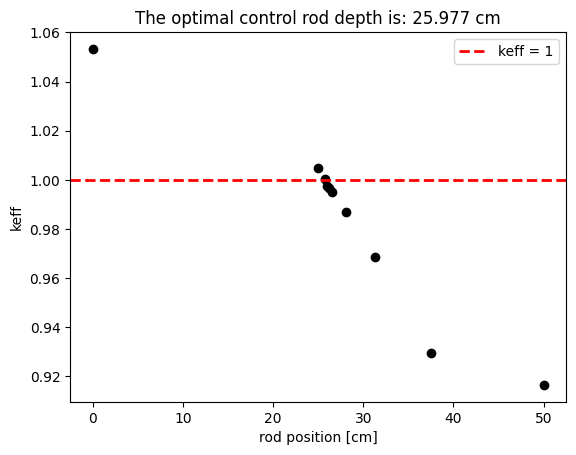

In [9]:
# Plot the results from the optimization and find the optimal depth.

plt.figure()
i = 0
for g,k in zip(guesses,opt_keffs):
    plt.scatter(g,k.nominal_value,color='k')
    i += 1
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label='keff = 1')
plt.xlabel('rod position [cm]')
plt.ylabel('keff')
plt.title(f'The optimal control rod depth is: {opt_depth:.3f} cm')
plt.legend()
plt.show()

# Conclusion
The critical control rod position is found at a depth of 26cm.